# GENERAL PyKeen PIPELINE

### IMPORTS

In [112]:
import os
from rdflib import Graph, URIRef
import pykeen
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import torch

### GENERATE DATASET

PyKeen expects a tsv dataset, so we need to transform from the .nt file to the .txt

In [72]:
input_file = os.path.join('constraintRDF.nt')
output_file = os.path.join('input.txt')

# Load the N-Triples file using rdflib
graph = Graph()
graph.parse(input_file, format="nt")

# Convert the graph to a tab-separated file
with open(output_file, 'w') as outfile:
    for s, p, o in graph:
        outfile.write(f"{s}\t{p}\t{o}\n")

C:\Users\34656\anaconda3\envs\PyKeen\lib\site-packages\rdflib\term.py:1695: UserWarning: Parsing weird boolean, '2250' does not map to True or False
  warnings.warn(


We load the dataset using the **TriplesFactory** class and then we split it training and testing. PyKeen does it for us, so that no unseen entity/relationship is in the testing split

In [73]:
tf = TriplesFactory.from_path('input.txt')
training, testing = tf.split()

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [3541, 1513]


### TRAIN THE MODEL

The model is trained, and a lot of the parameters (inlcuding the model, the training configuration, the optimizer...) can be modified. 

In [135]:
# Define the knowledge graph data location
training_data = training
testing_data = testing

# Define the model configuration
model = 'TransE'
model_kwargs = {'embedding_dim': 50}

# Define the training configuration
training_kwargs = {'num_epochs': 20, 'use_tqdm_batch':False}

# Define the optimizer configuration
optimizer_kwargs = {'lr':0.001}

# Define the evaluator configuration
evaluation_kwargs= {'batch_size':32,'use_tqdm':False}


# Define the pipeline
pipe = pipeline(
    model = model,
    training = training_data,
    testing = testing_data,
    training_loop = 'slcwa',
    model_kwargs = model_kwargs,
    training_kwargs = training_kwargs,
    optimizer_kwargs = optimizer_kwargs,
    evaluation_kwargs = evaluation_kwargs,
    negative_sampler = 'bernoulli',
    random_seed=1998
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 20/20 [00:05<00:00,  3.34epoch/s, loss=0.103, prev_loss=0.104]
INFO:pykeen.evaluation.evaluator:Evaluation took 1.07s seconds


### RESULTS

In [101]:
test_results = pipe.metric_results.to_df()

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

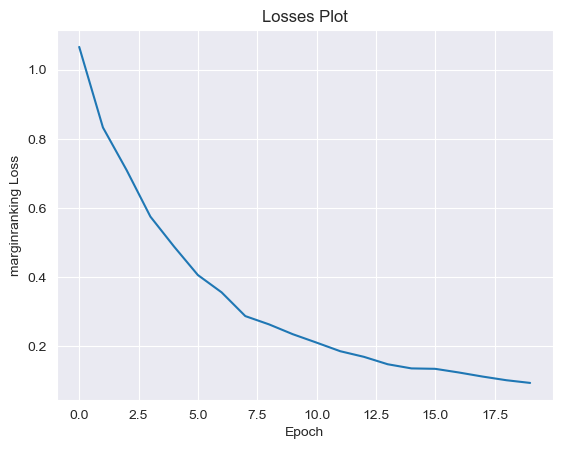

In [99]:
pipe.plot_losses()

Including in the pipe *evaluation_relation_whitelist = {'CtD', 'CpD'}*, the evaluations will only be done over the triples that contain such relationships. 

### STORE RESULTS

The best way may be to store all the pipeline, so we can access all the results. However, by now we need:
* The losses, for intramodel comparisson.
* The model_results for intra/intermodel comparissons.


We need to keep track also of the parameters that led to the results, namely:
* Name of the model.
* Embedding dimension.
* Learning rate?.

In [114]:
parameters = {'model':'TransE','emb_dim':50}
torch.save([parameters,test_results],'./results/results1.pkl')

### LOAD PREVIOUS RESULTS

In [115]:
p, t = torch.load('./results/results1.pkl')